
## Name : Muhammad Mubeen

## Degree : Environmental Science

## Course : Data Science

## University : College of Resources & Ennvironment, University of Chinese Academy of Sciences

## Data : MNIST




In [ ]:
import pickle
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, roc_auc_score, log_loss
import torch
from torchvision import transforms
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
import os
import scipy.misc

In [ ]:
with open("mnist.pkl", 'rb') as f:
    mnist = pickle.load(f)

In [ ]:
mnist

{'training_images': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'test_images': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'training_labels': array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 'test_labels': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)}

In [ ]:
X_train = mnist["training_images"]
y_train = mnist["training_labels"]
X_test = mnist["test_images"]
y_test = mnist["test_labels"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [ ]:
X_train = np.reshape(X_train, (-1, 28, 28))
X_train.shape

(60000, 28, 28)

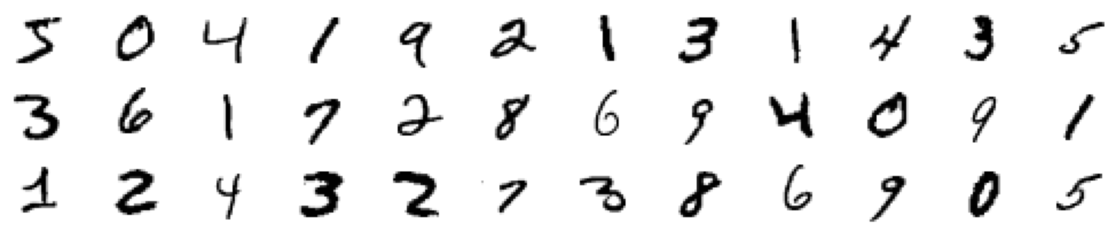

In [ ]:
plt.figure(figsize=(20,4))

for i in range(36):
    plt.subplot(3, 12, i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.axis('off')

plt.show()

In [ ]:
X_test = np.reshape(X_test, (-1, 28, 28))
X_test.shape

(10000, 28, 28)

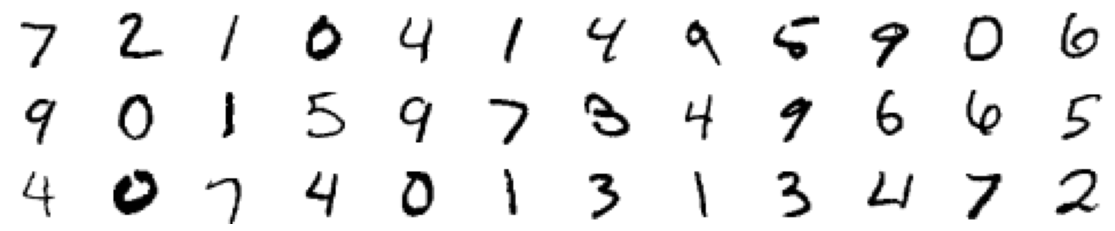

In [ ]:
plt.figure(figsize=(20,4))

for i in range(36):
    plt.subplot(3, 12, i+1)
    plt.imshow(X_test[i], cmap='binary')
    plt.axis('off')

plt.show()

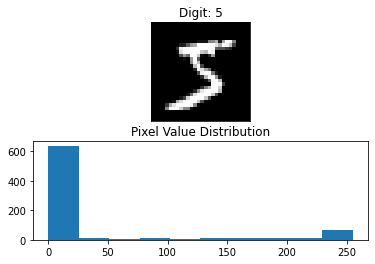

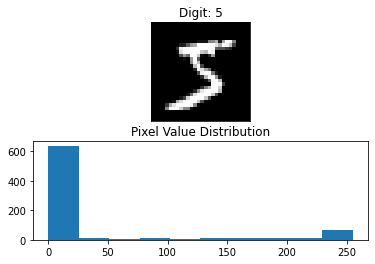

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

In [ ]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [ ]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


#### The one hot encoding is really a binary vector representation of categorical variables.
#### This requires first mapping the categorical values to integer values.
#### Then, each integer value is represented as a binary vector with all zero values except for the integer's index, which is denoted by a 1.

#### Let's use one-hot encoding to encode our categories (digits 0 to 9). The end result is a vector with the same length as the number of categories. Except for the position for the respective category, the vector is all zeroes. As a result, a '5' is represented by [0,0,0,0,1,0,0,0,0].

In [ ]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [ ]:
# building a sequntial model for linear stack of layers
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [ ]:
#tensorboard callback
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="log/", histogram_freq=1)

In [ ]:
# compilation of sequential model
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer='adam',
            )

In [ ]:
#call back function for epoch
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the data after 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function defination below)
      logs (dist) - metric results from the training epoch
    '''

    # check accuracy
    if(logs.get('loss') < 0.01):

      #stop if threshhold meet
      print("\nLoss is lower than 0.01 so canceling training")
      self.model.stop_training = True



# Instantiate Class
callbacks = myCallback()

In [ ]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=64,
          epochs=20,
          verbose=2,
          callbacks=[callbacks, tb_callback],
          validation_data=(X_test, Y_test),
          )
          

# saving the model
# save_dir = "/results/"
# model_name = 'keras_mnist.h5'
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)



Epoch 1/20
938/938 - 11s - loss: 0.0119 - accuracy: 0.9980 - val_loss: 0.1799 - val_accuracy: 0.9845 - 11s/epoch - 11ms/step
Epoch 2/20
938/938 - 10s - loss: 0.0156 - accuracy: 0.9976 - val_loss: 0.2069 - val_accuracy: 0.9831 - 10s/epoch - 11ms/step
Epoch 3/20
938/938 - 10s - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.2060 - val_accuracy: 0.9843 - 10s/epoch - 10ms/step
Epoch 4/20
938/938 - 10s - loss: 0.0131 - accuracy: 0.9975 - val_loss: 0.2228 - val_accuracy: 0.9835 - 10s/epoch - 11ms/step
Epoch 5/20
938/938 - 11s - loss: 0.0192 - accuracy: 0.9969 - val_loss: 0.1976 - val_accuracy: 0.9836 - 11s/epoch - 11ms/step
Epoch 6/20
938/938 - 10s - loss: 0.0140 - accuracy: 0.9976 - val_loss: 0.1912 - val_accuracy: 0.9832 - 10s/epoch - 10ms/step
Epoch 7/20
938/938 - 10s - loss: 0.0130 - accuracy: 0.9977 - val_loss: 0.2097 - val_accuracy: 0.9824 - 10s/epoch - 11ms/step
Epoch 8/20
938/938 - 10s - loss: 0.0141 - accuracy: 0.9978 - val_loss: 0.1692 - val_accuracy: 0.9865 - 10s/epoch - 11ms/step


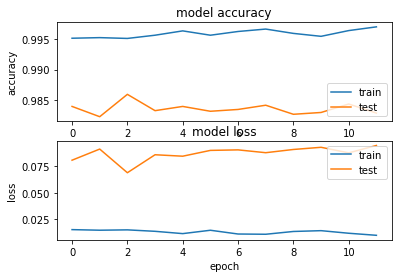

In [ ]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')


In [ ]:
loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

313/313 - 1s - loss: 0.0950 - accuracy: 0.9828 - 888ms/epoch - 3ms/step
Test Loss 0.09497397392988205
Test Accuracy 0.9828000068664551


In [ ]:
predictions = model.predict(X_test).argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


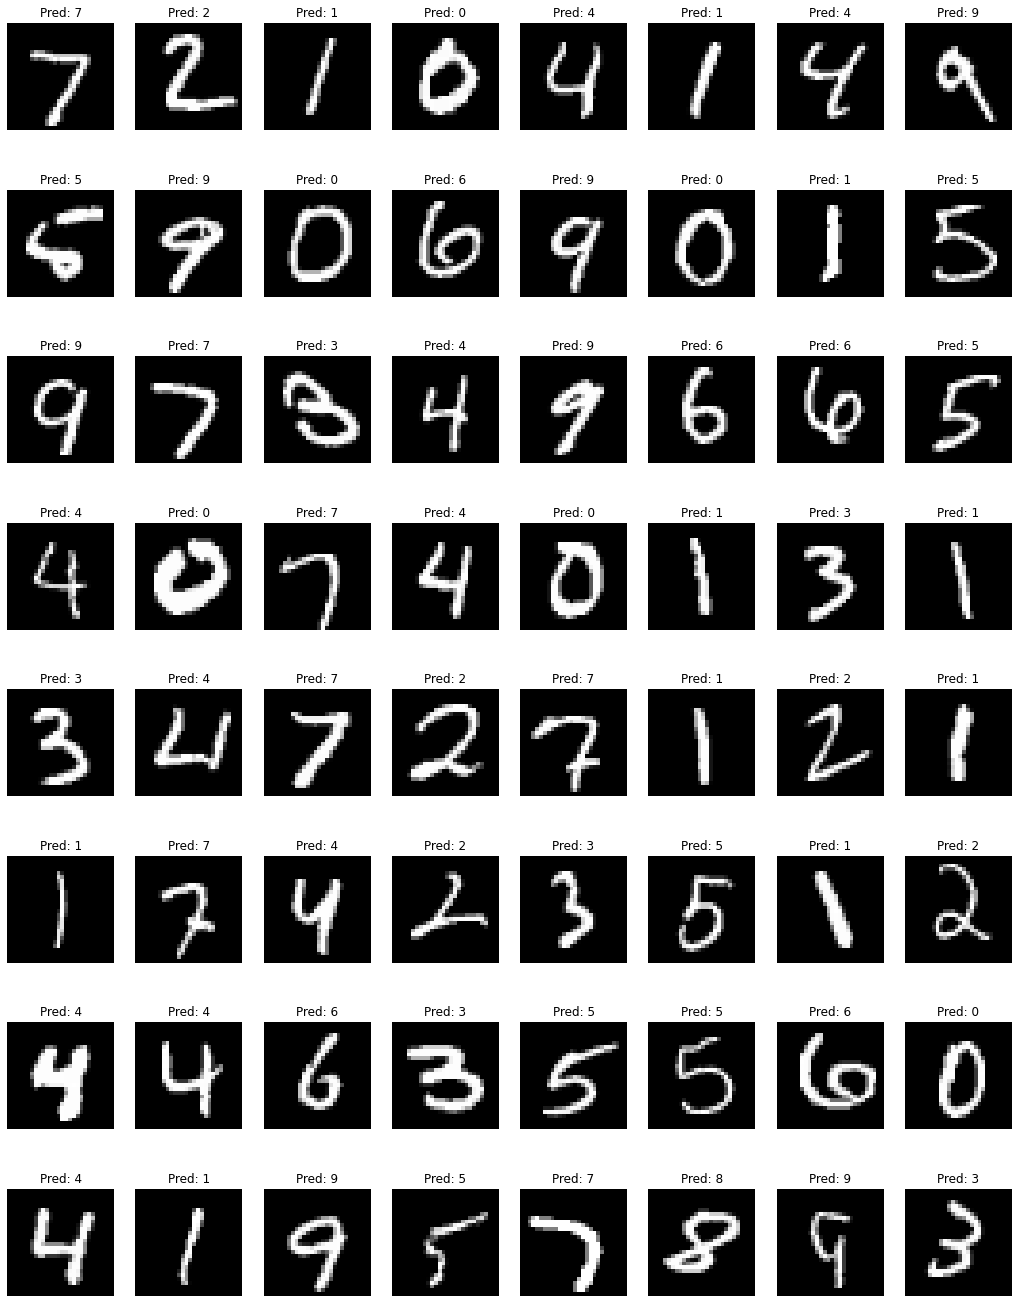

In [ ]:
# Display predictions
plt.figure(figsize=(18, 24))

for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Pred: {predictions[i]}")
    plt.axis('off')
    
plt.show()

### This model have accuracy of 99.8%, this is very high accuracy shows the the model is well trained.







<center>

THE END